# Datasets para modelos

In [1]:
# Números
import pandas as pd
import numpy as np

# Modelos
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import xgboost as xgb

# Visualizaciones
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['font.size'] = 12
import seaborn as sns
sns.set_style("darkgrid")
mpl.style.use('ggplot')

# Paletas
from matplotlib.colors import ListedColormap
from palettable.wesanderson import FantasticFox1_5

In [2]:
# Paletas a usar: contínua y discreta
FFox = FantasticFox1_5.mpl_colors # callable
FFoxC = FantasticFox1_5.mpl_colormap
FFoxD = ListedColormap(FantasticFox1_5.mpl_colors)

In [3]:
path_original = "..\\data\\original\\"
path_proc =  "..\\data\\processed\\"
path_ext = "..\\data\\external\\"

In [4]:
# Metadata
meta = pd.read_csv(path_ext + "feat_metadata.csv", sep=";")

# Funciones para la búsqueda bayesiana
fuente: https://www.kdnuggets.com/2019/07/xgboost-random-forest-bayesian-optimisation.html

In [3]:
#Bayesian optimization
def bayesian_optimization(dataset, function, parameters):
   X_train, y_train, X_test, y_test = dataset
   n_iterations = 500
   gp_params = {"alpha": 1e-4}

   BO = BayesianOptimization(function, parameters)
   BO.maximize(n_iter=n_iterations, **gp_params)

   return BO.max

In [4]:
# Optimization function
def xgb_optimization(cv_splits, eval_set):
    def function(eta, gamma, max_depth, colsample_bytree,subsample,min_child_weight):
            return cross_val_score(
                   xgb.XGBClassifier(
                       objective="binary:logistic",
                       learning_rate=max(eta, 0),
                       gamma=max(gamma, 0),
                       max_depth=int(max_depth),
                       colsample_bytree = max(colsample_bytree, 0), 
                       subsample =  max(subsample, 0),
                       min_child_weight = int(min_child_weight),                                       
                       seed=55,
                       nthread=-1,
                       random_state=55,
                       scale_pos_weight = len(y_train[y_train == 0])/
                                          len(y_train[y_train == 1])),  
                   X=X_train, 
                   y=y_train, 
                   cv=cv_splits,
                   scoring="roc_auc",
                   fit_params={
                        "early_stopping_rounds": 10, 
                        "eval_metric": "auc", 
                        "eval_set": eval_set},
                   n_jobs=-1).mean()

    parameters = {"eta": (0.0001, 0.4),
                  "gamma": (0, 20),
                  "colsample_bytree": (0.1,1),
                  "subsample": (0.1,1),
                  "min_child_weight": (2,500),
                  "max_depth": (100, 5000)}
                  
    
    return function, parameters

In [5]:
#Train model
def train(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 5
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = xgb.XGBClassifier(
                       objective="binary:logistic",
                       learning_rate=max(params["eta"], 0),
                       gamma=max(params["gamma"], 0),
                       max_depth=int(params["max_depth"]),
                       colsample_bytree = max(params["colsample_bytree"], 0), 
                       subsample =  max(params["subsample"], 0),   
                       min_child_weight = int(params["min_child_weight"]),                                                 
                       seed=55,
                       nthread=-1,
                       n_estimators = 5000,
                       random_state=55,
                       scale_pos_weight = len(y_train[y_train == 0])/
                                          len(y_train[y_train == 1]))
                       

    model.fit(X_train, y_train)
    
    return model

# Datasets

In [5]:
# Dev
dev = pd.read_csv(path_proc + "data_bal_dummy_dev.csv").set_index("id")
dev.drop("BMI",axis=1, inplace=True)
# Test
test = pd.read_csv(path_proc + "data_bal_dummy_test.csv").set_index("id")
test.drop("BMI",axis=1, inplace=True)

In [6]:
# Train test split
X_dev = dev.drop("target",axis=1).copy()
y_dev = dev.target.copy()
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, random_state=55)

In [7]:
X_test = test.drop("target",axis=1).copy()
y_test = test.target.copy()

# XGBoost

## Búsqueda

In [8]:
function, parameters = xgb_optimization(5, eval_set = [(X_val, y_val)])
parameters

{'eta': (0.0001, 0.4),
 'gamma': (0, 20),
 'colsample_bytree': (0.1, 1),
 'subsample': (0.1, 1),
 'min_child_weight': (2, 500),
 'max_depth': (100, 5000)}

In [9]:
model = train(X_train, y_train, X_val, y_val, function, parameters)

2   |  0.3696   |  0.1695   |  1.399    |  4.032e+0 |  3.196    |  0.4205   |
|  384      |  0.6941   |  0.556    |  0.2283   |  18.75    |  1.364e+0 |  35.41    |  0.4083   |
|  385      |  0.6907   |  0.9457   |  0.3352   |  1.292    |  3.883e+0 |  5.129    |  0.6002   |
|  386      |  0.7268   |  0.6011   |  0.03444  |  0.7215   |  1.727e+0 |  12.66    |  0.6176   |
|  387      |  0.5668   |  0.2245   |  0.1043   |  20.0     |  3.282e+0 |  88.84    |  0.5267   |
|  388      |  0.7163   |  0.9899   |  0.1414   |  1.136    |  3.183e+0 |  28.59    |  0.4441   |
|  389      |  0.7227   |  0.1702   |  0.1591   |  3.143    |  3.392e+0 |  33.66    |  0.6294   |
|  390      |  0.5      |  0.2674   |  0.2774   |  0.3065   |  3.398e+0 |  174.8    |  0.7086   |
|  391      |  0.6426   |  0.5345   |  0.156    |  0.1774   |  548.7    |  126.3    |  0.9505   |
|  392      |  0.6971   |  0.2479   |  0.2589   |  3.555    |  1.705e+0 |  2.418    |  0.1829   |
|  393      |  0.5      |  0.6945   |  0

In [10]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9622422627177102,
              gamma=14.596822338754238, learning_rate=0.24285196984144164,
              max_delta_step=0, max_depth=2839, min_child_weight=6,
              missing=None, n_estimators=5000, n_jobs=1, nthread=-1,
              objective='binary:logistic', random_state=55, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.9569569569569569, seed=55,
              silent=None, subsample=0.8600929404156575, verbosity=1)

## Test

### Model 0

- Se optimizan eta, gamma, max_depth, colsample_bytree, subsample, min_child_weight.
- Se usan todas las variables.

In [ ]:
model0 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9622422627177102,
              gamma=14.596822338754238, learning_rate=0.24285196984144164,
              max_delta_step=0, max_depth=2839, min_child_weight=6,
              missing=None, n_estimators=5000, n_jobs=1, nthread=-1,
              objective='binary:logistic', random_state=55, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.9569569569569569, seed=55,
              silent=None, subsample=0.8600929404156575, verbosity=1)

In [12]:
model0.fit(X_dev, y_dev)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9622422627177102,
              gamma=14.596822338754238, learning_rate=0.24285196984144164,
              max_delta_step=0, max_depth=2839, min_child_weight=6,
              missing=None, n_estimators=5000, n_jobs=1, nthread=-1,
              objective='binary:logistic', random_state=55, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.9569569569569569, seed=55,
              silent=None, subsample=0.8600929404156575, verbosity=1)

In [20]:
y_pred0 = model0.predict(X_test)

In [21]:
roc_auc_score(y_test, y_pred0)

0.7172517123287672

In [22]:
print(classification_report(y_test, y_pred0))

precision    recall  f1-score   support

           0       0.73      0.72      0.73       320
           1       0.70      0.72      0.71       292

    accuracy                           0.72       612
   macro avg       0.72      0.72      0.72       612
weighted avg       0.72      0.72      0.72       612



### Model 1

Sobre los parámetros encontrados para modelo 0 se modifican:
- profundidad del árbol: 5000
- estimadores: muchos más, 10000

In [8]:
model1 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9622422627177102,
              gamma=14.596822338754238, learning_rate=0.24285196984144164,
              max_delta_step=0, max_depth=5000, min_child_weight=6,
              missing=None, n_estimators=10000, n_jobs=1, nthread=-1,
              objective='binary:logistic', random_state=55, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.9569569569569569, seed=55,
              silent=None, subsample=0.8600929404156575, verbosity=1)

In [9]:
model1.fit(X_dev, y_dev)

XGBClassifier(colsample_bytree=0.9622422627177102, gamma=14.596822338754238,
              learning_rate=0.24285196984144164, max_depth=5000,
              min_child_weight=6, n_estimators=10000, nthread=-1,
              random_state=55, scale_pos_weight=0.9569569569569569, seed=55,
              subsample=0.8600929404156575)

In [10]:
# Feature importance
features = list(X_dev.columns)
importances = list(model1.feature_importances_)
df_importances = pd.DataFrame({"feature":features, "importance":importances})

df_importances = df_importances.sort_values("importance", ascending=False)
#plt.barh(df_importances.feature, df_importances.importance)

In [11]:
temp = pd.merge(df_importances, meta[["code","question","category"]], how="left", left_on="feature",right_on="code").drop("code",axis=1).head(10)

In [13]:
temp

,feature,importance,question,category
0,PAINECK,0.132298,¿Ha sufrido dolor de cuello durante más de 24 ...,enfermedades crónicas
1,SEX_2,0.106466,NaN,NaN
2,PAINLB,0.083384,¿Ha sufrido dolor de cintura durante más de 24...,enfermedades crónicas
3,AGE_P,0.061349,Edad,sujeto
4,PAINFACE,0.060683,¿Ha sufrido dolor de en la cara o la mandíbula...,enfermedades crónicas
5,RACERPI2_4,0.049337,NaN,NaN
6,SINYR,0.049194,¿Ha sido diagnosticado con sinusitis en los úl...,antecedentes
7,HYPYR1,0.038616,¿Ha sufrido hipertemsión en los últimos 12 meses?,antecedentes
8,ASICPUSE_3,0.036620,NaN,NaN
9,MOD,0.035623,¿Cuántos minutos a la semana realiza de ejerci...,hábitos


In [14]:
temp.loc[temp.feature.isin(["SEX_2","AGE_P","RACERPI2_4"]) == True,"category"] = "sujeto"
temp.loc[temp.feature.isin(["ASICPUSE_3"]) == True,"category"] = "hábitos"
temp

,feature,importance,question,category
0,PAINECK,0.132298,¿Ha sufrido dolor de cuello durante más de 24 ...,enfermedades crónicas
1,SEX_2,0.106466,NaN,sujeto
2,PAINLB,0.083384,¿Ha sufrido dolor de cintura durante más de 24...,enfermedades crónicas
3,AGE_P,0.061349,Edad,sujeto
4,PAINFACE,0.060683,¿Ha sufrido dolor de en la cara o la mandíbula...,enfermedades crónicas
5,RACERPI2_4,0.049337,NaN,sujeto
6,SINYR,0.049194,¿Ha sido diagnosticado con sinusitis en los úl...,antecedentes
7,HYPYR1,0.038616,¿Ha sufrido hipertemsión en los últimos 12 meses?,antecedentes
8,ASICPUSE_3,0.036620,NaN,hábitos
9,MOD,0.035623,¿Cuántos minutos a la semana realiza de ejerci...,hábitos


Text(0.5, 1.0, 'Importancia de variables en el modelo XGBoost (top 10)')

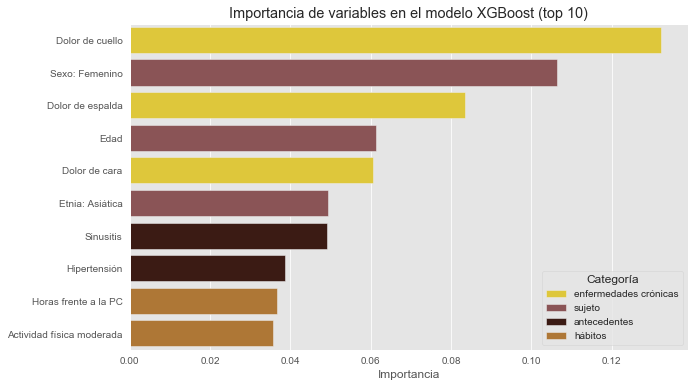

In [15]:
g = sns.barplot(data=temp, x="importance", y="feature", orient="h", hue="category", dodge=False, palette=FFox)
g.set_yticklabels(['Dolor de cuello','Sexo: Femenino','Dolor de espalda','Edad','Dolor de cara','Etnia: Asiática','Sinusitis','Hipertensión', "Horas frente a la PC", "Actividad física moderada"])
g.set(xlabel='Importancia', ylabel='')
leg = g.get_legend()
leg.set_title("Categoría")
g.set_title("Importancia de variables en el modelo XGBoost (top 10)")

In [47]:
g.figure.savefig("..\\figures\\XGB_importancia.png", dpi=150, bbox_inches='tight')

In [9]:
y_pred1 = model1.predict(X_test)

In [10]:
roc_auc_score(y_test, y_pred1)

0.7255779109589041

In [11]:
print(classification_report(y_test, y_pred1))

precision    recall  f1-score   support

           0       0.73      0.76      0.74       320
           1       0.72      0.69      0.71       292

    accuracy                           0.73       612
   macro avg       0.73      0.73      0.73       612
weighted avg       0.73      0.73      0.73       612



In [12]:
classification_report(y_test, y_pred1,output_dict=True)

{'0': {'precision': 0.7297297297297297,
  'recall': 0.759375,
  'f1-score': 0.7442572741194486,
  'support': 320},
 '1': {'precision': 0.7240143369175627,
  'recall': 0.6917808219178082,
  'f1-score': 0.7075306479859895,
  'support': 292},
 'accuracy': 0.7271241830065359,
 'macro avg': {'precision': 0.7268720333236462,
  'recall': 0.7255779109589041,
  'f1-score': 0.7258939610527191,
  'support': 612},
 'weighted avg': {'precision': 0.727002777603663,
  'recall': 0.7271241830065359,
  'f1-score': 0.7267341126309355,
  'support': 612}}